## Initialisation

### Dependencies

#### Third party

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### Personal notebook

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 0.01
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 470
Young's Modulus: 19.761925308919306 GPa
13562 469
Yield Strength: 481.4689680000001 MPa
Ultimate Tensile Strength is 524.425548 MPa at 31.816329999999997% elongation.


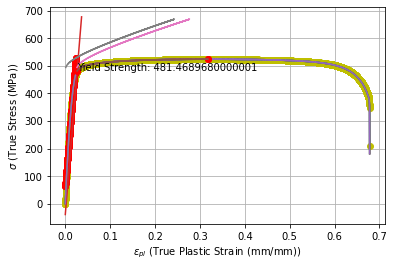

In [2]:
import ipynb

from ipynb.fs.defs.utilities import (
    differentiate,
)
from ipynb.fs.full.true_strain_stress import (
    true_plastic_strain,
    true_stress,
    true_strain,
)

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\epsilon$

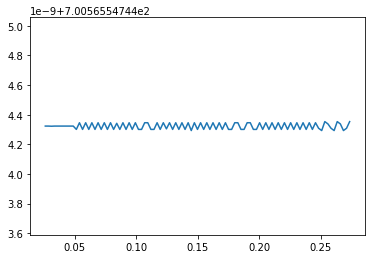

In [28]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

true_stress_smooth = smooth(true_stress,1)
# _ = plt.plot (true_strain, true_stress_smooth, 'bo')
# _ = plt.plot(true_strain, true_stress, color = 'yellow')


reduced_true_strain = np.linspace(min(true_strain),max(true_strain),100)
reduced_true_stress = np.linspace(min(true_stress_smooth),max(true_stress_smooth),100)

d_sigma_epsilon = differentiate(reduced_true_strain, reduced_true_stress)

_ = plt.plot(reduced_true_strain[:99], d_sigma_epsilon)